# Student Grade Prediction Model


## Load the dataset


### Importing required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.metrics import *
from pprint import pprint
import xgboost as xgb

metrics = {
    "accuracy_score": [],
    "precision_score": [],
    "recall_score": [],
    "f1_score": [],
    "classifier": [],
}


def save_metrics(y_test, pred, classifier):
    metrics["accuracy_score"].append(accuracy_score(y_test, pred))
    metrics["precision_score"].append(precision_score(y_test, pred, average="macro"))
    metrics["recall_score"].append(recall_score(y_test, pred, average="macro"))
    metrics["f1_score"].append(f1_score(y_test, pred, average="macro"))
    metrics["classifier"].append(classifier)

### Loading the dataset


In [2]:
path = "data/xAPI-Edu-Data.csv"
df = pd.read_csv(path)

## Preprocessing Data


### Dropping Unnecessary Columns


In [3]:
df.drop(
    [
        "StageID",
        "GradeID",
        "SectionID",
        "Semester",
        "NationalITy",
        "Topic",
        "PlaceofBirth",
    ],
    axis=1,
    inplace=True,
)

### Encoding data


In [4]:
encoder = OneHotEncoder(sparse_output=False, drop="if_binary")
categorical_features = df.select_dtypes(include="object")
encoded_array = encoder.fit_transform(categorical_features)

encoded_columns = encoder.get_feature_names_out(categorical_features.columns)

encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns)

df_final = df.drop(columns=categorical_features.columns).reset_index(drop=True)
df_final = pd.concat([df_final, encoded_df], axis=1)

### Splitting the Dataset into Training and Testing sets


In [5]:
feature = df_final.drop(["Class_H", "Class_M", "Class_L"], axis=1)
label = df_final[["Class_H", "Class_M", "Class_L"]]
x_train, x_test, y_train, y_test = train_test_split(
    feature, label, test_size=0.2, random_state=42
)

## Predict Student Grade


### Tune Parameters using GridSearchCV


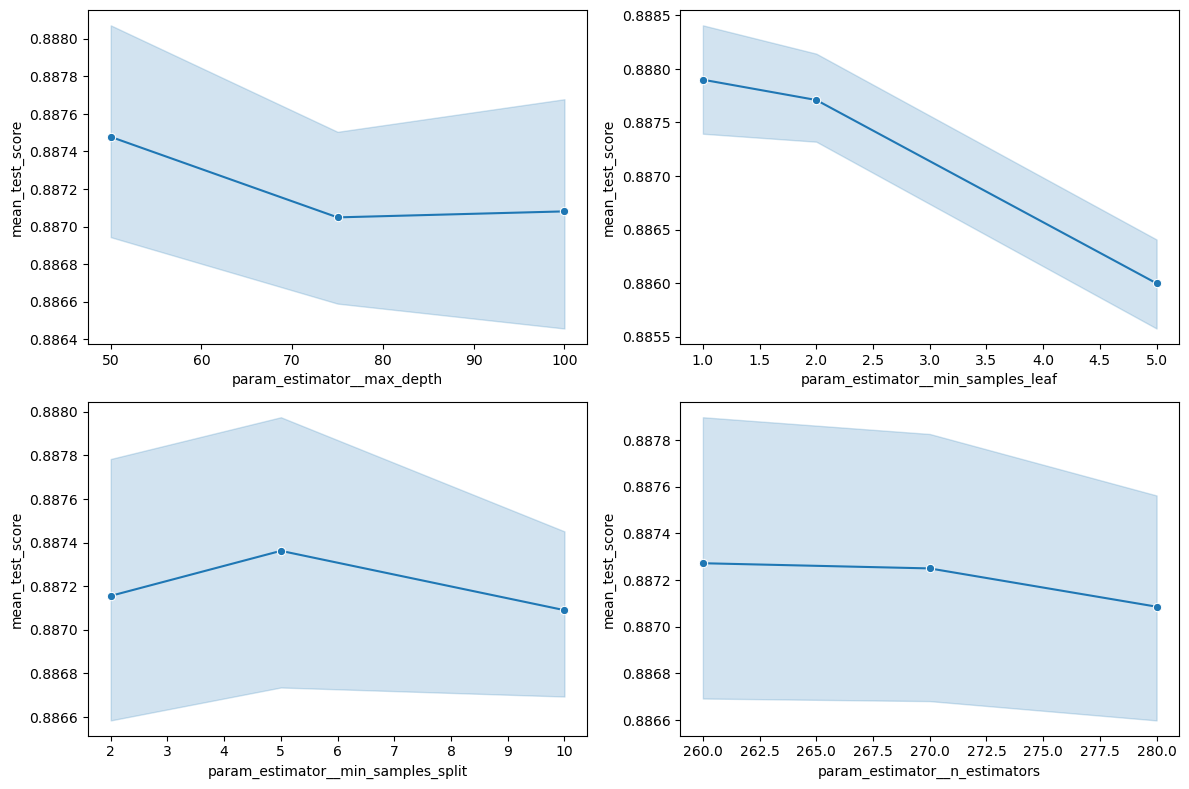

In [6]:
param_grid = {
    "estimator__n_estimators": [260, 270, 280],
    "estimator__max_depth": [50, 75, 100],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 5],
}

model = OneVsRestClassifier(RandomForestClassifier())

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
grid_search.fit(x_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)
param_columns = [col for col in results_df.columns if col.startswith("param_")]
results_df = results_df[param_columns + ["mean_test_score"]]

plt.figure(figsize=(12, 8))
for i, param in enumerate(param_columns, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=results_df, x=param, y="mean_test_score", marker="o")
plt.tight_layout()
plt.show()

### Visualize ROC Curve


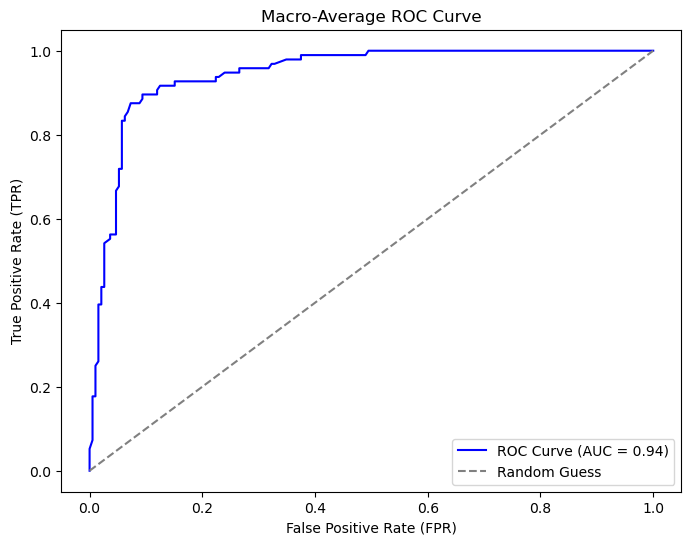

In [7]:
best_params = grid_search.best_params_
best_model = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=best_params["estimator__n_estimators"],
        max_depth=best_params["estimator__max_depth"],
        min_samples_split=best_params["estimator__min_samples_split"],
        min_samples_leaf=best_params["estimator__min_samples_leaf"],
        random_state=42,
    ),
    n_jobs=1,
)
best_model.fit(x_train, y_train)
pred = best_model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), pred.ravel())
roc_auc = roc_auc_score(y_test, pred, average="macro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Macro-Average ROC Curve")
plt.legend()
plt.show()

### Predict using Random Forest Classifier


In [8]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
pred = (pred >= optimal_threshold).astype(int)
save_metrics(y_test, pred, "Random Forest")

### Tune Parameters using GridSearchCV


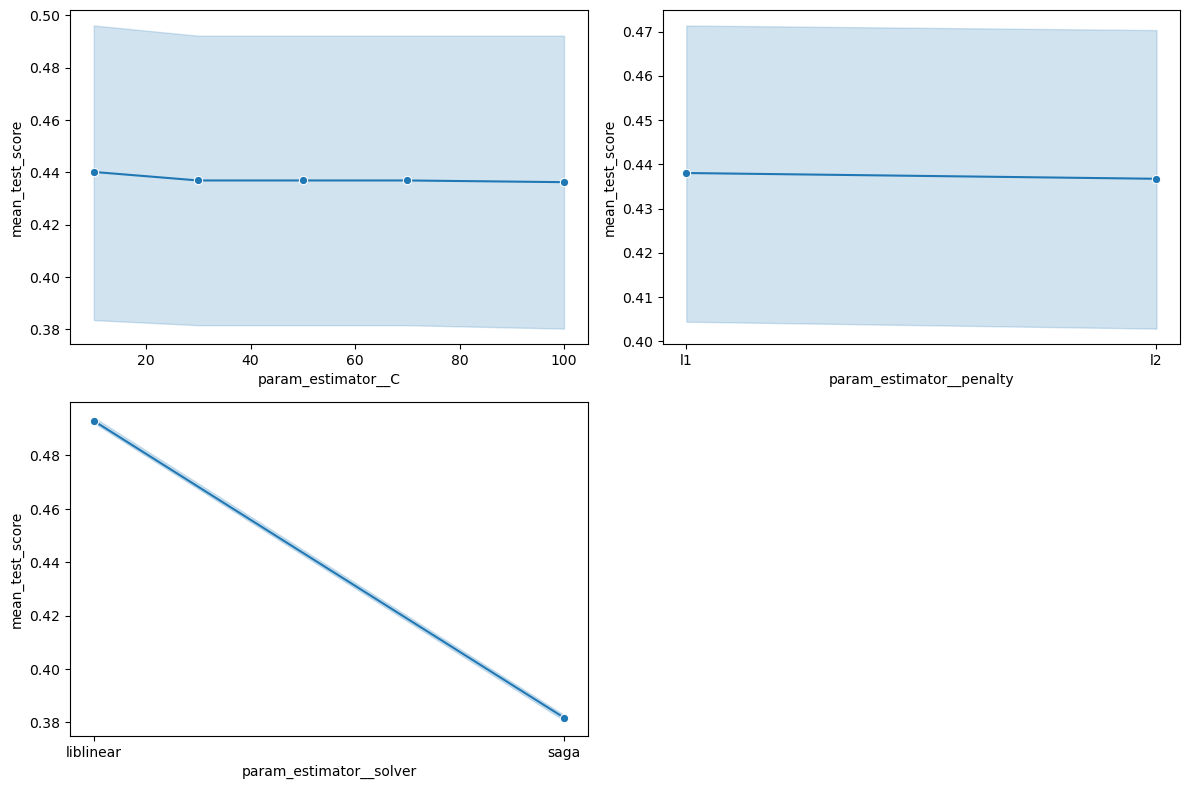

In [9]:
param_grid = {
    "estimator__C": [10, 30, 50, 70, 100],
    "estimator__penalty": ["l1", "l2"],
    "estimator__solver": ["liblinear", "saga"],
}

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(x_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)
param_columns = [col for col in results_df.columns if col.startswith("param_")]
results_df = results_df[param_columns + ["mean_test_score"]]

plt.figure(figsize=(12, 8))
for i, param in enumerate(param_columns, 1):
    plt.subplot(2, 2, i)
    sns.lineplot(data=results_df, x=param, y="mean_test_score", marker="o")
plt.tight_layout()
plt.show()

### Visualize ROC Curve


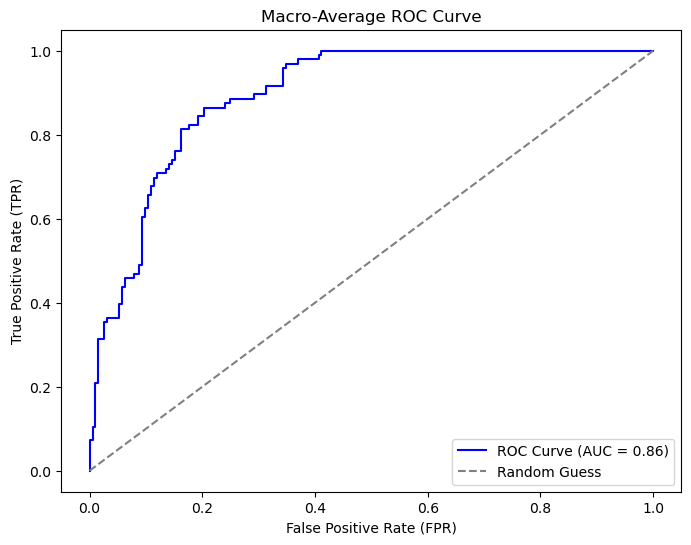

In [10]:
best_params = grid_search.best_params_
best_model = OneVsRestClassifier(
    LogisticRegression(
        C=best_params["estimator__C"],
        penalty=best_params["estimator__penalty"],
        solver=best_params["estimator__solver"],
    )
)
best_model.fit(x_train, y_train)
pred = best_model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), pred.ravel())
roc_auc = roc_auc_score(y_test, pred, average="macro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Macro-Average ROC Curve")
plt.legend()
plt.show()

### Predict using Logistic Regression


In [11]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
pred = (pred >= optimal_threshold).astype(int)
save_metrics(y_test, pred, "Logistic Regression")

### Encoding Data


In [12]:
encoder = LabelEncoder()

df_final["Class"] = encoder.fit_transform(df["Class"])
df_final = df_final.drop(["Class_H", "Class_M", "Class_L"], axis=1)

### Splitting the Dataset into Training and Testing sets


In [13]:
feature = df_final.drop(["Class"], axis=1)
label = df_final[["Class"]]
x_train, x_test, y_train, y_test = train_test_split(
    feature, label, test_size=0.2, random_state=42
)

### Tune Parameters using GridSearchCV


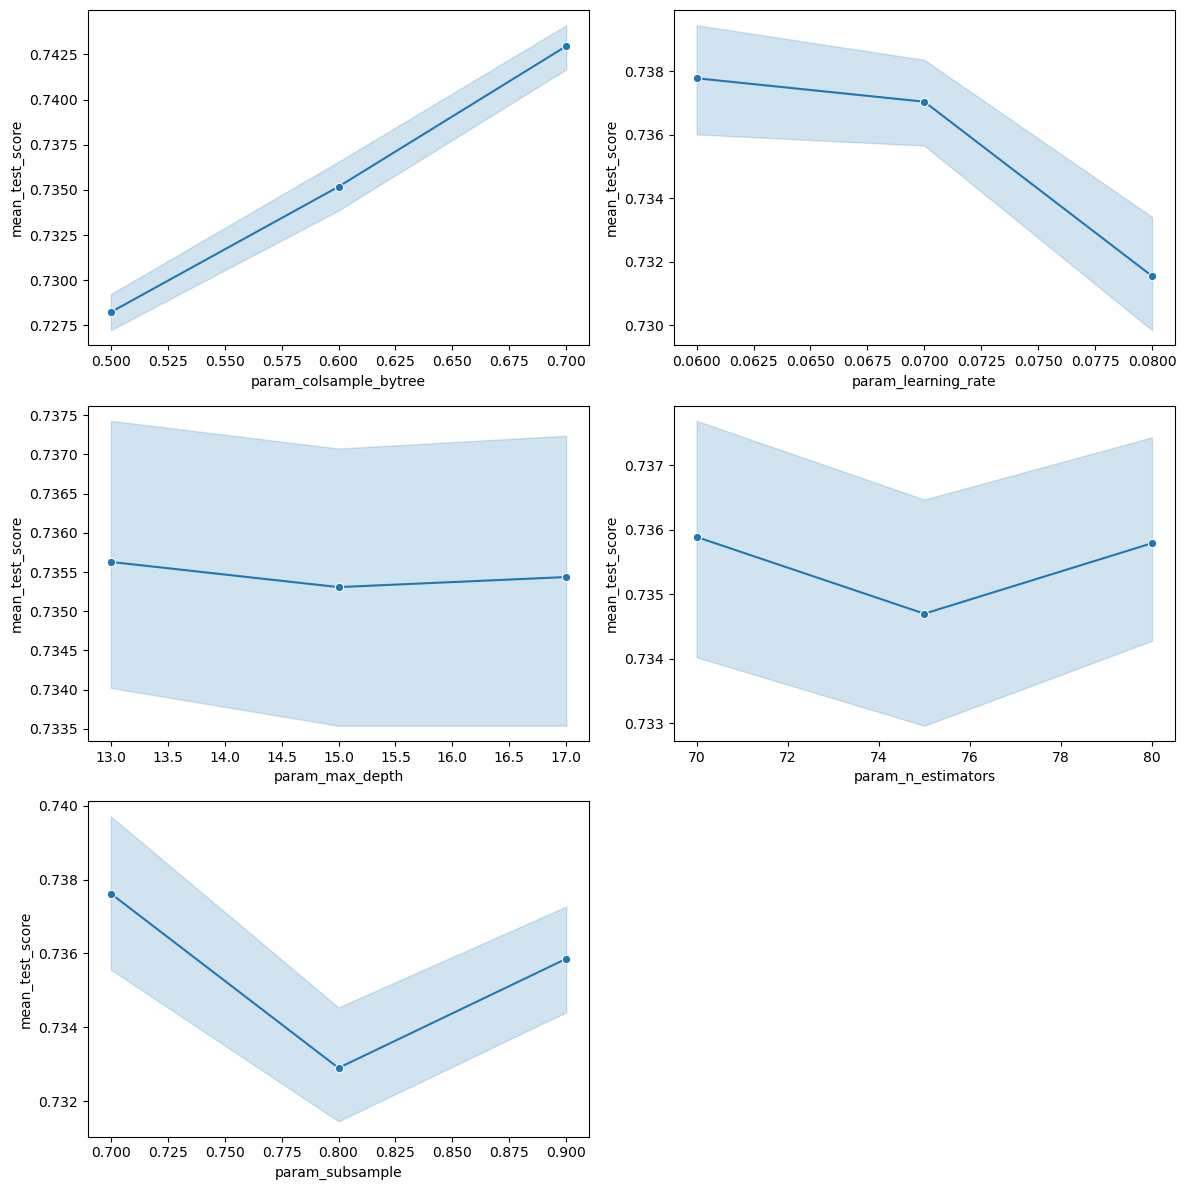

In [14]:
param_grid = {
    "max_depth": [13, 15, 17],
    "learning_rate": [0.06, 0.07, 0.08],
    "n_estimators": [70, 75, 80],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.5, 0.6, 0.7],
}

model = xgb.XGBClassifier(
    objective="multi:softmax", num_class=3, eval_metric="mlogloss"
)

grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(x_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)
param_columns = [col for col in results_df.columns if col.startswith("param_")]
results_df = results_df[param_columns + ["mean_test_score"]]

plt.figure(figsize=(12, 12))
for i, param in enumerate(param_columns, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(data=results_df, x=param, y="mean_test_score", marker="o")
plt.tight_layout()
plt.show()

### Visualize ROC Curve


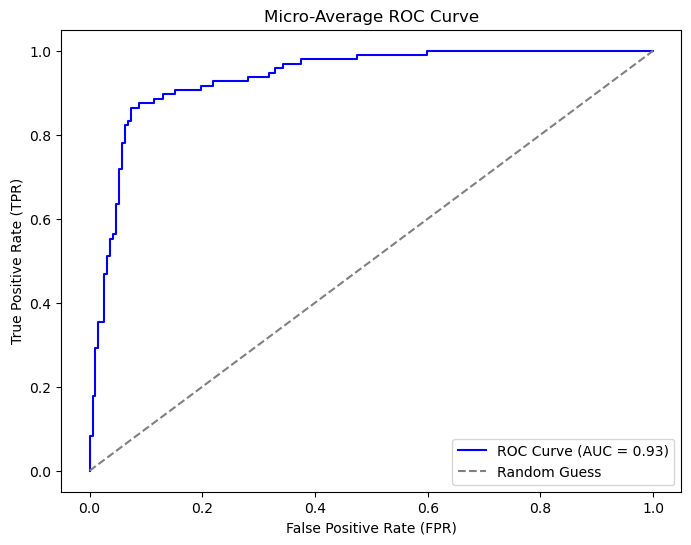

In [15]:
best_params = grid_search.best_params_
best_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    **best_params,
)
best_model.fit(x_train, y_train)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
pred = best_model.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test_bin.ravel(), pred.ravel())
roc_auc = roc_auc_score(y_test, pred, average="macro", multi_class="ovr")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Micro-Average ROC Curve")
plt.legend()
plt.show()

### Predict using XGBoost


In [16]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
pred = np.argmax(pred, axis=1)
save_metrics(y_test, pred, "XGBoost")

## Compare Models


### Visualize Model Performance


<Figure size 1000x600 with 0 Axes>

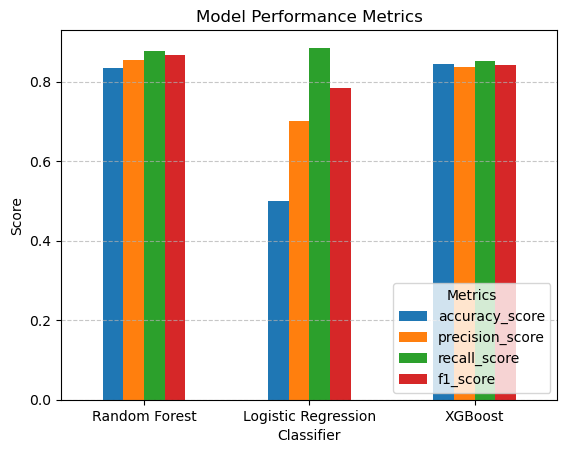

In [17]:
df_metric = pd.DataFrame(metrics)


df_metric.set_index("classifier", inplace=True)
fig = plt.figure(figsize=(10, 6))
df_metric.plot(kind="bar")
plt.xlabel("Classifier")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.title("Model Performance Metrics")
plt.legend(title="Metrics", loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()